# Unsupervised Learning - DBSCAN, t-SNE

### DBSCAN

DBSCAN (Density-based spatial clustering of applications with noise) is a density based clustering algorithm, which ahs the feature of detecting outliers.

The main steps are the following:<br>
1) Find the points in the ε (eps) neighborhood of every point, and identify the core points with more than minPts neighbors.<br>
2) Find the connected components of core points on the neighbor graph, ignoring all non-core points.<br>
3) Assign each non-core point to a nearby cluster if the cluster is an ε (eps) neighbor, otherwise assign it to noise.

![alt text](https://miro.medium.com/max/2174/0*bUyZlx3rbNneiUA_)

The GIF below shows in step by step how DBSCAN works.

![alt text](https://media.giphy.com/media/lCL2GQewp7fkk/giphy.gif)

The GIF below shows how DBSCAN works in fast way.

![alt text](https://media.giphy.com/media/OVJBPIB6oL3a0/giphy.gif)

In [0]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [0]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)
X = StandardScaler().fit_transform(X)

In [0]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [19]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}'  )
print(f'Estimated number of noise points: {n_noise_}'  )
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels)}")

Estimated number of clusters: 3
Estimated number of noise points: 18
Silhouette Coefficient: 0.6255247640253795


Silhouette Coefficient measure how consistent the clustering is. The idea is to see how much each point is closer to another cluster than it has been assigned to and calculate the average of those distances.

For point $i$ we calculate the distance from all other points in its cluster. $$a(i) =\frac{1}{|C_i|-1} \sum_{j\in C_i}d(i,j)$$

Then for point $i$ we calculate the distance between all points of the closest cluster (we calculate mean distance from each cluster, then take which is the smallest). $$b(i) = \min\limits_k \frac{1}{|C_k|} \sum_{j\in C_k}d(i,j)$$, where $C_k$ is the closest cluster and $k \neq i$ .

So silhouette coeficient for point $i$ is defined as $$s(i)=\frac{b(i)-a(i)}{max(a(i),b(i))}$$

And lastly the silhouette coefficient for all points is the mean of the silhouette coefficient of each point. $$s = \frac{1}{N}\sum_is(i)$$

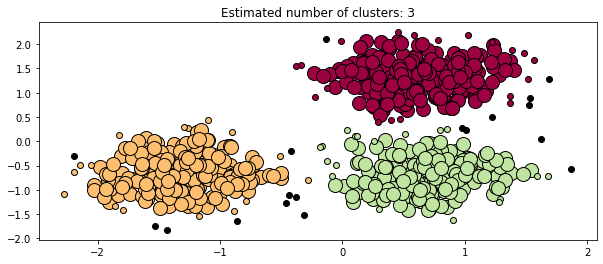

In [20]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize = (10,4))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'Estimated number of clusters: {n_clusters_}' )
plt.show()

### t-SNE

t-SNE (T-distributed Stochastic Neighbor Embedding) is a non-linear density based clustring technique. It is mainly used to reduce the dimension of data and have easier way to visualize it.

![alt text](https://miro.medium.com/max/1313/1*a39T3o9QDA6lgj-R1NKo-Q.gif)

**First step** is to calculate the similarity matrix between all points  in high dimension using Gaussian kernel:

$$p_{j/i} = \frac{-exp(||x_i-x_j||^2/2\sigma_i^2)}{\sum_{k\neq i}{-exp(||x_i-x_k||^2/2\sigma_i^2})}$$

**Second step** is to readjust the similarities as calculating $p_{i/j}$ would have different value.

$$p_{ij} =  \frac{p_{i/j}+p_{j/i}}{2N}$$

**Third step** is to randomly initialize $y_i$ in a lower dimension we choose. And calculate the similarties in the lower dimension with t-distribution kernel.

$$q_{ij} = \frac {(1+||y_i-y_j||^2)^{-1}}{\sum_{k\neq i}(1-||y_i-y_k||^2)^{-1}}$$

**Fourth step** is to calculate the KL divergence and then interatively update $y$-s using numeric methods.

$$KL = \sum_{i \neq j} {p_{ij}log(\frac{p_{ij}}{q_{ij}})}$$

t-SNE paper: http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from time import time
from matplotlib import offsetbox
from sklearn import manifold, random_projection, datasets
import imageio
import glob
from tqdm import tqdm
from skimage.transform import resize as imresize

In [23]:
X = np.zeros((760*4,8*8))
y = np.zeros([760*4]).astype(object)
c = 0
for path_part in ['Բ','ո','ր','ա']:
    images = glob.glob(f'/content/drive/My Drive/AI Bootcamp/Courses/Week 4 Day 1: PCA, SVD, DBSCAN, tSNE/DBSCAN,t-SNE/{path_part}/*.png')
    for image in tqdm(images[:760]):        
        im = imresize(imageio.imread(image),(8,8)).flatten()
        X[c] = im
        y[c] = path_part
        c+=1
        
n_samples, n_features = X.shape

100%|██████████| 760/760 [00:03<00:00, 250.84it/s]


In [0]:
y_num = np.array([{'Բ':0,'ո':2,'ր':4,'ա':7}[i] for i in y])

In [0]:
# Scale and visualize the embedding vectors
def plot_embedding(Z, title=None):
    x_min, x_max = np.min(Z, 0), np.max(Z, 0)
    Z = (Z - x_min) / (x_max - x_min)

    plt.figure(figsize = (10,4))
    ax = plt.subplot(111)
    for i in tqdm(range(X.shape[0])):
        plt.text(Z[i, 0], Z[i, 1], y[i],
                 color=plt.cm.Set1(y_num[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

 10%|▉         | 303/3040 [00:00<00:00, 3022.09it/s]

Computing random projection


100%|██████████| 3040/3040 [00:01<00:00, 1909.60it/s]


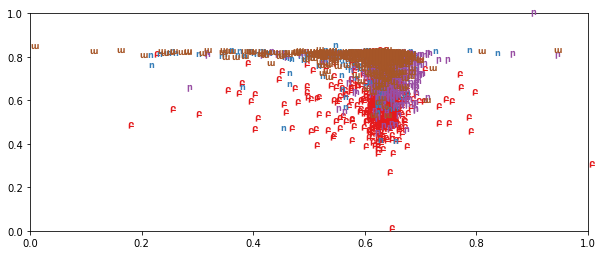

Computing t-SNE embedding
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 3040 samples in 0.013s...
[t-SNE] Computed neighbors for 3040 samples in 1.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3040
[t-SNE] Computed conditional probabilities for sample 2000 / 3040
[t-SNE] Computed conditional probabilities for sample 3000 / 3040
[t-SNE] Computed conditional probabilities for sample 3040 / 3040
[t-SNE] Mean sigma: 0.078793
[t-SNE] Computed conditional probabilities in 0.508s
[t-SNE] Iteration 50: error = 68.9331360, gradient norm = 0.0001203 (50 iterations in 2.691s)
[t-SNE] Iteration 100: error = 68.9300537, gradient norm = 0.0001484 (50 iterations in 1.632s)
[t-SNE] Iteration 150: error = 68.9303055, gradient norm = 0.0001093 (50 iterations in 1.466s)
[t-SNE] Iteration 200: error = 68.9302444, gradient norm = 0.0004522 (50 iterations in 1.482s)
[t-SNE] Iteration 250: error = 68.9302902, gradient norm = 0.0000781 (50 iterations in 1.374s)
[t-SNE] KL d

 10%|█         | 309/3040 [00:00<00:00, 3082.79it/s]

[t-SNE] Iteration 1500: error = 1.4247581, gradient norm = 0.0000111 (50 iterations in 1.819s)
[t-SNE] KL divergence after 1500 iterations: 1.424758


100%|██████████| 3040/3040 [00:01<00:00, 2181.49it/s]


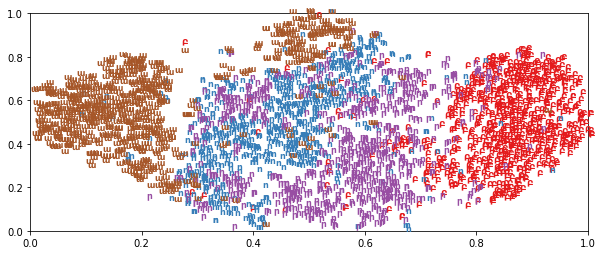

In [26]:
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")

plt.show()
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, verbose = 2, perplexity=80, n_iter = 1500)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))
plt.show()

In [27]:
# Compute DBSCAN
db = DBSCAN(eps=2, min_samples=10).fit(X_tsne)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}' )
print(f'Estimated number of noise points: {n_noise_}' )
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels)}")

Estimated number of clusters: 6
Estimated number of noise points: 125
Silhouette Coefficient: 0.027939476244688902


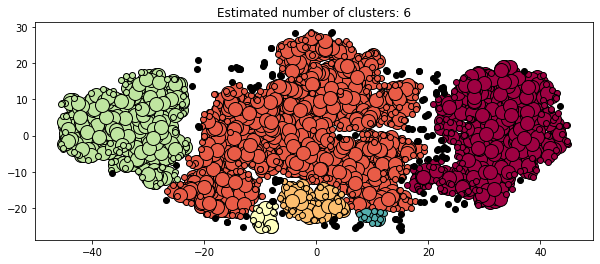

In [28]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize = (10,4))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_tsne[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_tsne[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'Estimated number of clusters: {n_clusters_}' )
plt.show()